In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split, StratifiedKFold, KFold

In [18]:
file_path = 'C:\\hudsondata\\Machine Learning\\TalkingData'
train = pd.read_csv(os.path.join(file_path,'gender_age_train.csv'))
test = pd.read_csv(os.path.join(file_path,'gender_age_test.csv'))
phone = pd.read_csv(os.path.join(file_path,'phone_brand_device_model.csv'))

In [19]:
phone = phone.drop_duplicates('device_id', keep='last')
print 'The shape of train is ', train.shape, 'the shape for test is', test.shape, 'the shape for phone is', phone.shape

The shape of train is  (74645, 4) the shape for test is (112071, 1) the shape for phone is (186716, 3)


In [20]:
brandencoder = LabelEncoder().fit(phone['phone_brand'])
modelencoder = LabelEncoder().fit(phone['phone_brand'].map(str)+phone['device_model'])
groupencoder = LabelEncoder().fit(train['group'])
phone['brand'] = brandencoder.transform(phone['phone_brand'])
phone['model'] = modelencoder.transform(phone['phone_brand'].map(str)+phone['device_model'])
phone = phone.drop(['phone_brand','device_model'],axis=1)
train['classes'] = groupencoder.transform(train['group'])
train = train.drop(['group'],axis=1)

In [21]:
train = pd.merge(train, phone, on='device_id', how='left')
test = pd.merge(test, phone, on='device_id', how='left')
print 'The shape of train is', train.shape, 'the shape of test is', test.shape

The shape of train is (74645, 6) the shape of test is (112071, 3)


In [22]:
train2 = train.drop(['gender','age'], axis=1)
print 'The shape of train2 is', train2.shape

The shape of train2 is (74645, 4)


In [23]:
y=train2['classes']
train2 =train2[['device_id','brand','model','classes']]

In [39]:
def model(joined, testy, ytest, num):    #joined is train_merge, X_test is test_merge

    groupj = joined.groupby(['model','classes']).size().unstack().fillna(0)
    priorj = pd.DataFrame((pd.DataFrame(joined['classes'].value_counts().sort_index()/len(joined))).as_matrix().reshape(1,12))
    groupjsum = groupj.copy()
    groupjsum['sum'] = groupjsum.sum(axis=1)
    groupjsum['weight'] = [ 29 if x<10 else num for x in groupjsum['sum']]
    groupjsum['weightandsum'] = groupjsum['sum']+groupjsum['weight']
    model_weight = groupjsum['weight']
    priorjmult = priorj.append([priorj]*((groupjsum.shape[0]-1))).set_index(groupjsum.index)
    priorjweight = priorjmult.mul(model_weight,axis=0)
    groupjsum2 = groupjsum.drop(['sum','weight','weightandsum'],axis=1)
    groupjsum3 = groupjsum2.add(priorjweight)
    weight_sum = groupjsum['weightandsum']
    groupjsum3 = groupjsum3.div(weight_sum,axis=0)
    
    groupj2 = joined.groupby(['brand','classes']).size().unstack().fillna(0)
    groupj2sum = groupj2.copy()
    groupj2sum['sum'] = groupj2sum.sum(axis=1)
    groupj2sum['weight'] = [ 40 if x<10 else 30 for x in groupj2sum['sum']]
    groupj2sum['weightandsum'] = groupj2sum['sum']+groupj2sum['weight']
    model_weight2 = groupj2sum['weight']
    priorj2mult = priorj.append([priorj]*((groupj2sum.shape[0]-1))).set_index(groupj2sum.index)
    priorj2weight = priorj2mult.mul(model_weight2,axis=0)
    groupj2sum2 = groupj2sum.drop(['sum','weight','weightandsum'],axis=1)
    groupj2sum3 = groupj2sum2.add(priorj2weight)
    weight_sum2 = groupj2sum['weightandsum']
    groupj2sum3 = groupj2sum3.div(weight_sum2,axis=0)
    
    merged = pd.merge(testy,groupjsum3.reset_index(), how ='left', on='model').set_index(testy.index)
    nanvalues = merged[pd.isnull(merged).any(axis=1)].drop((np.arange(0,12)),axis=1)
    merged = merged.dropna()
    
    nanvalues2 = nanvalues.merge(groupj2sum3.reset_index(), how="left").set_index(nanvalues.index)
    merged = merged.append(nanvalues2)
    benchmark = merged[pd.isnull(merged).any(axis=1)].fillna(0).add(priorj.ix[0])
    benchmark2 = benchmark.drop(['brand','device_id','model'],axis=1)
    benchmark2 = benchmark2.join(test) #to add the device ids back
    merged= merged.dropna()
    merged = merged.append(benchmark2).sort_index()
    merged = merged.drop(['brand','device_id','model','classes'],axis=1).sort_index()
    return merged.as_matrix()

In [40]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
weights = [10,20,30,40,50,60,70,80,90,100]
for num in weights:
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        merged = model(trainy,testy,ytest,num)
        accuracy = log_loss(ytest,merged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4191292207570601, 2.4180961392025009, 2.4180004148070817, 2.4180451417213438, 2.4181134399969455, 2.4181802405511696, 2.4182399800217125, 2.4182920945449071, 2.4183373279136813, 2.4183766741509345]


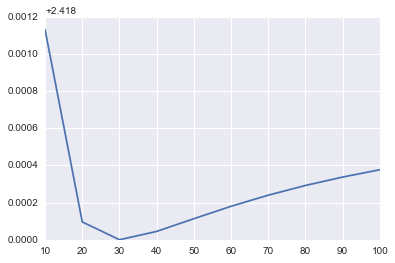

In [41]:
plt.plot(weights,mean_list)

In [42]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
weights = [25,26,27,28,29,30,31,32,33,34,35]
for num in weights:
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        merged = model(trainy,testy,ytest,num)
        accuracy = log_loss(ytest,merged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4180137811737965, 2.4180073781093436, 2.4180031527992512, 2.4180007657314961, 2.4179999327029553, 2.4180004148070817, 2.4180020104393716, 2.418004548871846, 2.4180078850568023, 2.4180118954004777, 2.4180164743070387]


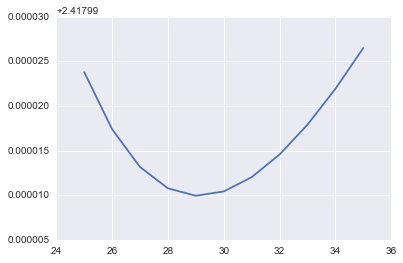

In [43]:
plt.plot(weights,mean_list)

In [44]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
weights = [10,20,30,40,50,60,70,80,90,100]
for num in weights:
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        merged = model(trainy,testy,ytest,num)
        accuracy = log_loss(ytest,merged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4191292207570601, 2.4180961392025009, 2.4180004148070817, 2.4180451417213438, 2.4181134399969455, 2.4181802405511696, 2.4182399800217125, 2.4182920945449071, 2.4183373279136813, 2.4183766741509345]


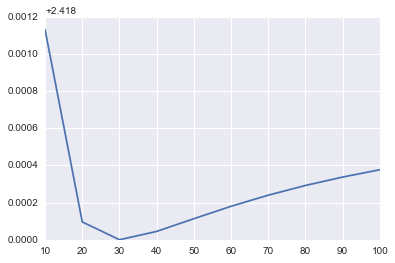

In [45]:
plt.plot(weights,mean_list)

In [46]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
weights = [25,26,27,28,29,30,31,32,33,34,35]
for num in weights:
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        merged = model(trainy,testy,ytest,num)
        accuracy = log_loss(ytest,merged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4180137811737965, 2.4180073781093436, 2.4180031527992512, 2.4180007657314961, 2.4179999327029553, 2.4180004148070817, 2.4180020104393716, 2.418004548871846, 2.4180078850568023, 2.4180118954004777, 2.4180164743070387]


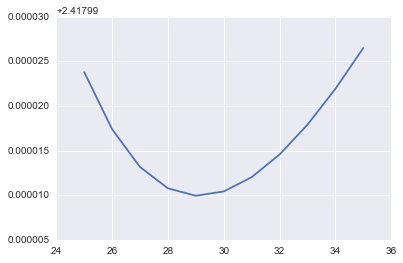

In [47]:
plt.plot(weights,mean_list)

In [53]:
def brand(joined, testy, ytest, num):    #joined is train_merge, X_test is test_merge

    groupj = joined.groupby(['brand','classes']).size().unstack().fillna(0)
    priorj = pd.DataFrame((pd.DataFrame(joined['classes'].value_counts().sort_index()/len(joined))).as_matrix().reshape(1,12))
    groupjsum = groupj.copy()
    groupjsum['sum'] = groupjsum.sum(axis=1)
    groupjsum['weight'] = [100 if x<10 else num for x in groupjsum['sum']]
    groupjsum['weightandsum'] = groupjsum['sum']+groupjsum['weight']
    model_weight = groupjsum['weight']
    priorjmult = priorj.append([priorj]*((groupjsum.shape[0]-1))).set_index(groupjsum.index)
    priorjweight = priorjmult.mul(model_weight,axis=0)
    groupjsum2 = groupjsum.drop(['sum','weight','weightandsum'],axis=1)
    groupjsum3 = groupjsum2.add(priorjweight)
    weight_sum = groupjsum['weightandsum']
    groupjsum3 = groupjsum3.div(weight_sum,axis=0)
    
    groupj2 = joined.groupby(['model','classes']).size().unstack().fillna(0)
    groupj2sum = groupj2.copy()
    groupj2sum['sum'] = groupj2sum.sum(axis=1)
    groupj2sum['weight'] = [ 40 if x<10 else 30 for x in groupj2sum['sum']]
    groupj2sum['weightandsum'] = groupj2sum['sum']+groupj2sum['weight']
    model_weight2 = groupj2sum['weight']
    priorj2mult = priorj.append([priorj]*((groupj2sum.shape[0]-1))).set_index(groupj2sum.index)
    priorj2weight = priorj2mult.mul(model_weight2,axis=0)
    groupj2sum2 = groupj2sum.drop(['sum','weight','weightandsum'],axis=1)
    groupj2sum3 = groupj2sum2.add(priorj2weight)
    weight_sum2 = groupj2sum['weightandsum']
    groupj2sum3 = groupj2sum3.div(weight_sum2,axis=0)
    
    merged = pd.merge(testy,groupjsum3.reset_index(), how ='left', on='brand').set_index(testy.index)
    nanvalues = merged[pd.isnull(merged).any(axis=1)].drop((np.arange(0,12)),axis=1)
    merged = merged.dropna()
    
    nanvalues2 = nanvalues.merge(groupj2sum3.reset_index(), how="left").set_index(nanvalues.index)
    merged = merged.append(nanvalues2)
    benchmark = merged[pd.isnull(merged).any(axis=1)].fillna(0).add(priorj.ix[0])
    benchmark2 = benchmark.drop(['brand','device_id','model'],axis=1)
    benchmark2 = benchmark2.join(test) #to add the device ids back
    merged= merged.dropna()
    merged = merged.append(benchmark2).sort_index()
    merged = merged.drop(['brand','device_id','model','classes'],axis=1).sort_index()
    return merged.as_matrix()

In [51]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
weights = [10,20,30,40,50,60,70,80,90,100]
for num in weights:
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        merged = brand(trainy,testy,ytest,num)
        accuracy = log_loss(ytest,merged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.408105767509118, 2.4076176161360783, 2.4073545884079621, 2.4071780353312877, 2.4070464978076629, 2.4069423713501044, 2.4068566437158694, 2.4067841123424585, 2.4067215095554548, 2.4066666506665988]


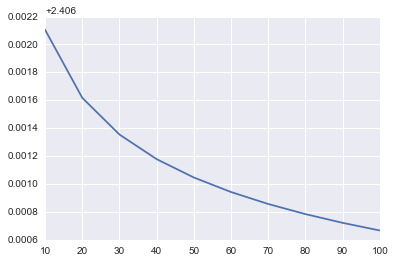

In [52]:
plt.plot(weights,mean_list)

In [54]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
weights = [10,20,30,40,50,60,70,80,90,100]
for num in weights:
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        merged = brand(trainy,testy,ytest,num)
        accuracy = log_loss(ytest,merged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4069596274589915, 2.4067402408177299, 2.4066611058524892, 2.4066205763078168, 2.406596025633855, 2.4065795903639722, 2.4065678297450521, 2.406559003428633, 2.4065521379369454, 2.4065466467428736]


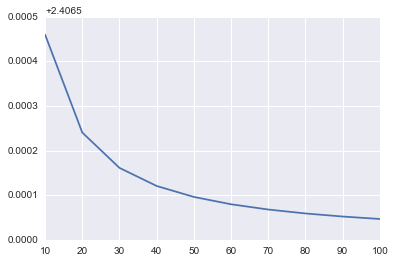

In [55]:
plt.plot(weights,mean_list)

In [66]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
a=np.arange(0.1,1,0.1)
b=np.arange(0.9,0,-0.1)
for a,b in zip(a,b):
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        mergedbrand = brand(trainy,testy,ytest,100)
        mergedmodel = model(trainy,testy,ytest,29)
        supermerged = (pd.DataFrame(mergedbrand).mul(a)).add(pd.DataFrame(mergedmodel).mul(b))
        supermerged = supermerged.as_matrix()
        accuracy = log_loss(ytest,supermerged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4138535985357761, 2.4104745496679842, 2.4077971537262419, 2.4057772615603286, 2.404385528224005, 2.4036039553291246, 2.4034241248069153, 2.4038465172713761, 2.4048807234852472]


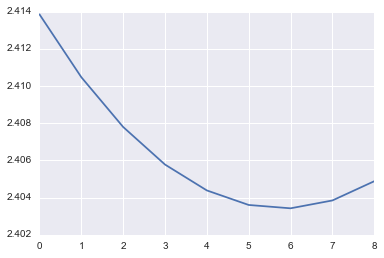

In [68]:
plt.plot(mean_list)

In [69]:
print "This means that the merge model should be 0.7 and the brand model should 0.3x"

This means that the merge model should be 0.7 and the brand model should 0.3x


In [72]:
mean_list=[]
kf = StratifiedKFold(y,n_folds=10,random_state=0)
a=np.arange(0.65,0.75,0.01)
b=np.arange(0.35,0.26,-0.01)
for a,b in zip(a,b):
    for itrain, itest in kf:
        accuracy_list=[]
        trainy = train2.iloc[itrain,:]
        testy = train2.iloc[itest,:]
        ytrain, ytest = y[itrain],y[itest]
        mergedbrand = brand(trainy,testy,ytest,100)
        mergedmodel = model(trainy,testy,ytest,29)
        supermerged = (pd.DataFrame(mergedbrand).mul(a)).add(pd.DataFrame(mergedmodel).mul(b))
        supermerged = supermerged.as_matrix()
        accuracy = log_loss(ytest,supermerged)
        accuracy_list.append(accuracy)
    mean_list.append(np.mean(accuracy_list))
print mean_list

[2.4034389989795732, 2.403424014861705, 2.4034150331732773, 2.4034120556857337, 2.4034150850512725, 2.4034241248069153, 2.4034391793794581, 2.4034602540913039, 2.4034873551672171]


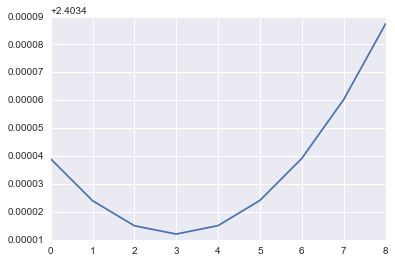

In [73]:
plt.plot(mean_list)

In [75]:
print 'The ideal mix is model at 0.68 and brand at 0.32 at 2.403412'

The ideal mix is model at 0.68 and brand at 0.32 at 2.403412
